In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score,r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
Auto_df = pd.read_csv("auto_1993_adj.csv")

print(Auto_df.describe())

               ID  displacement   cylinders  horsepower       weight  \
count  398.000000    398.000000  398.000000  392.000000   398.000000   
mean   199.500000    193.425879    5.454774  104.469388  2970.424623   
std    115.036951    104.269838    1.701004   38.491160   846.841774   
min      1.000000     68.000000    3.000000   46.000000  1613.000000   
25%    100.250000    104.250000    4.000000   75.000000  2223.750000   
50%    199.500000    148.500000    4.000000   93.500000  2803.500000   
75%    298.750000    262.000000    8.000000  126.000000  3608.000000   
max    398.000000    455.000000    8.000000  230.000000  5140.000000   

       acceleration  model_year      origin         mpg  
count    398.000000  398.000000  398.000000  398.000000  
mean      15.568090   76.010050    1.572864   23.514573  
std        2.757689    3.697627    0.802055    7.815984  
min        8.000000   70.000000    1.000000    9.000000  
25%       13.825000   73.000000    1.000000   17.500000  
50%

In [3]:
Auto_df.isnull().sum()
Auto_df.dropna()
Auto_df = Auto_df.drop("ID", axis=1)

In [4]:
print(Auto_df.duplicated().value_counts())
Auto_df.drop_duplicates()

False    398
Name: count, dtype: int64


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0
...,...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1,27.0
394,97.0,4,52.0,2130,24.6,82,2,44.0
395,135.0,4,84.0,2295,11.6,82,1,32.0
396,120.0,4,79.0,2625,18.6,82,1,28.0


In [5]:
X = Auto_df.drop("mpg", axis=1)
print(X.describe())
y = Auto_df["mpg"]

print(X.shape)
print(y.shape)

       displacement   cylinders  horsepower       weight  acceleration  \
count    398.000000  398.000000  392.000000   398.000000    398.000000   
mean     193.425879    5.454774  104.469388  2970.424623     15.568090   
std      104.269838    1.701004   38.491160   846.841774      2.757689   
min       68.000000    3.000000   46.000000  1613.000000      8.000000   
25%      104.250000    4.000000   75.000000  2223.750000     13.825000   
50%      148.500000    4.000000   93.500000  2803.500000     15.500000   
75%      262.000000    8.000000  126.000000  3608.000000     17.175000   
max      455.000000    8.000000  230.000000  5140.000000     24.800000   

       model_year      origin  
count  398.000000  398.000000  
mean    76.010050    1.572864  
std      3.697627    0.802055  
min     70.000000    1.000000  
25%     73.000000    1.000000  
50%     76.000000    1.000000  
75%     79.000000    2.000000  
max     82.000000    3.000000  
(398, 7)
(398,)


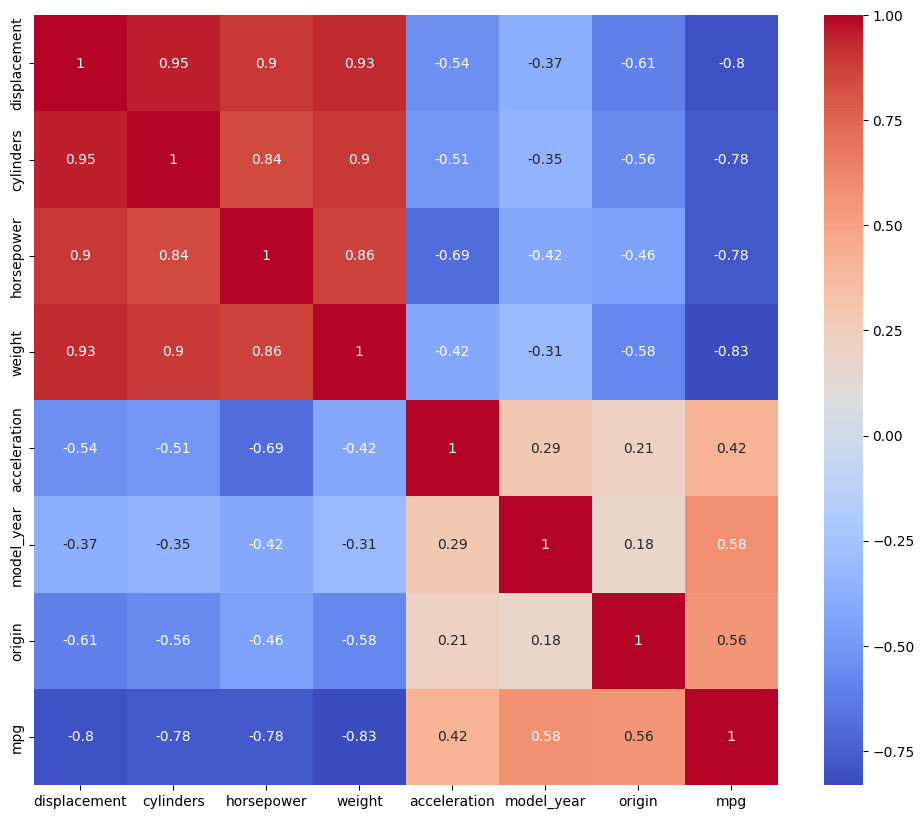

In [19]:
EDA_df = Auto_df.copy()

corr_matrix = EDA_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show() 

array([[<Axes: title={'center': 'displacement'}>,
        <Axes: title={'center': 'cylinders'}>,
        <Axes: title={'center': 'horsepower'}>],
       [<Axes: title={'center': 'weight'}>,
        <Axes: title={'center': 'acceleration'}>,
        <Axes: title={'center': 'model_year'}>],
       [<Axes: title={'center': 'origin'}>,
        <Axes: title={'center': 'mpg'}>, <Axes: >]], dtype=object)

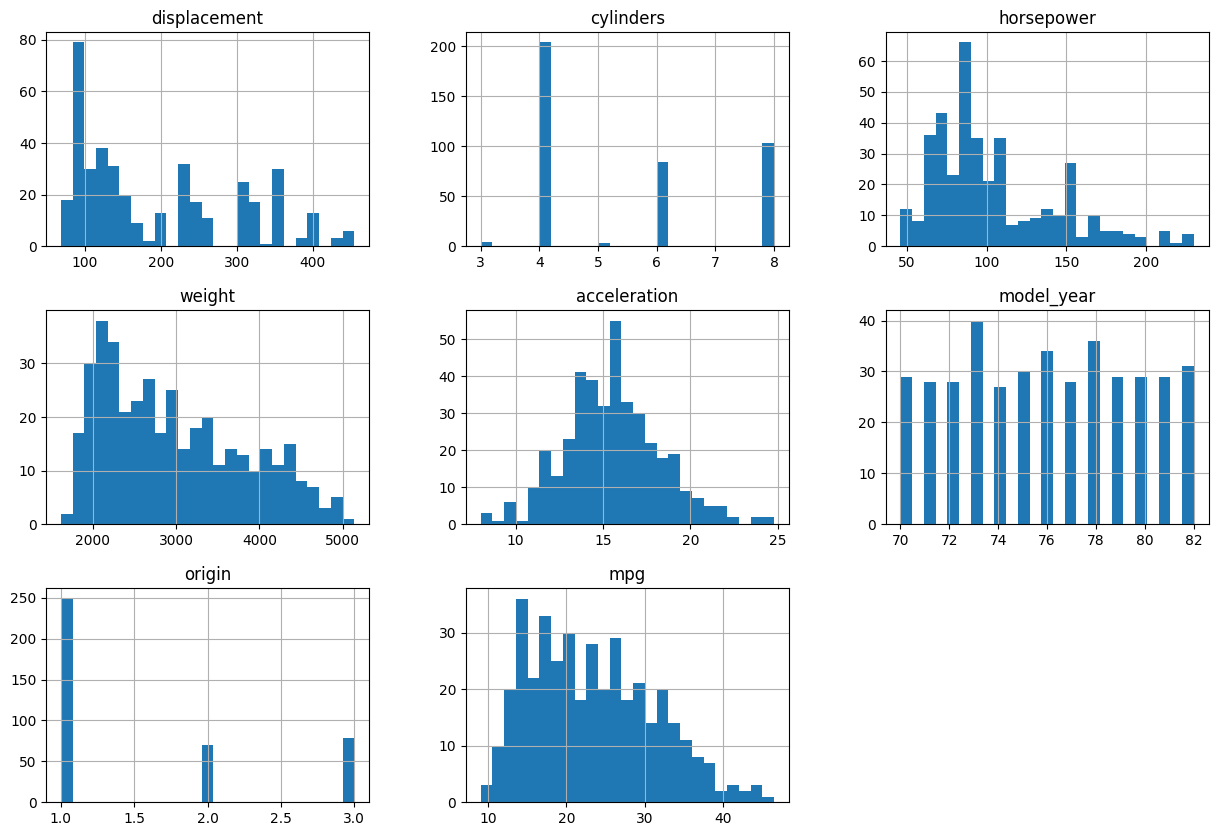

In [7]:

EDA_df .hist(bins = 25, figsize = (15,10))  

In [8]:
#Create new features
X["cylinders_by_displacement"] = X["cylinders"]/ X["displacement"]
X["weight_by_displacement"] = X["weight"]/ X["displacement"]
X["horsepower_by_displacement"] = X["horsepower"]/ X["displacement"]
X["weight_by_cylinders"] = X["weight"]/ X["cylinders"]
print(X.shape)

(398, 11)


In [9]:
feature_sets = [
    ['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration', 'model_year'],
    ['displacement', 'cylinders', 'horsepower', 'weight', 'model_year'],
    ['displacement', 'cylinders', 'horsepower', 'weight', 'acceleration'],
    ['model_year', 'cylinders', 'acceleration', 'weight',"horsepower_by_displacement"],
    [ 'cylinders', 'horsepower', 'acceleration', 'weight_by_displacement'],
    ['horsepower', 'weight', 'acceleration', 'model_year', 'cylinders_by_displacement'],
]
results_df = pd.DataFrame(columns=['Feature Set', 'Model', 'r2','MSE','mean_absolute_percentage'])
for features in feature_sets:
    try:
        X_features = X[features]
        y = Auto_df['mpg']

        # Impute missing values
        imputer = SimpleImputer()
        X_imputed = pd.DataFrame(imputer.fit_transform(X_features), columns=X_features.columns)


        # Scale features
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

        # Define models
        models = {
            'KNN Regressor': KNeighborsRegressor(),
            'Linear SVR': SVR(),
            'Ridge Regressor': Ridge()
        }

        # Train and evaluate models
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2=r2_score(y_test, y_pred)
            mean_absolute_percentage=mean_absolute_percentage_error(y_test, y_pred)
            results_df.loc[len(results_df.index)] = [', '.join(features), model_name,r2, mse,mean_absolute_percentage]
 

    except Exception as e:
        print(f"Error processing feature set {', '.join(features)}: {e}")

# Display results
print(results_df)

                                          Feature Set            Model  \
0   displacement, cylinders, horsepower, weight, a...    KNN Regressor   
1   displacement, cylinders, horsepower, weight, a...       Linear SVR   
2   displacement, cylinders, horsepower, weight, a...  Ridge Regressor   
3   displacement, cylinders, horsepower, weight, m...    KNN Regressor   
4   displacement, cylinders, horsepower, weight, m...       Linear SVR   
5   displacement, cylinders, horsepower, weight, m...  Ridge Regressor   
6   displacement, cylinders, horsepower, weight, a...    KNN Regressor   
7   displacement, cylinders, horsepower, weight, a...       Linear SVR   
8   displacement, cylinders, horsepower, weight, a...  Ridge Regressor   
9   model_year, cylinders, acceleration, weight, h...    KNN Regressor   
10  model_year, cylinders, acceleration, weight, h...       Linear SVR   
11  model_year, cylinders, acceleration, weight, h...  Ridge Regressor   
12  cylinders, horsepower, acceleratio

Text(0.5, 1.0, 'Mean Squared Error')

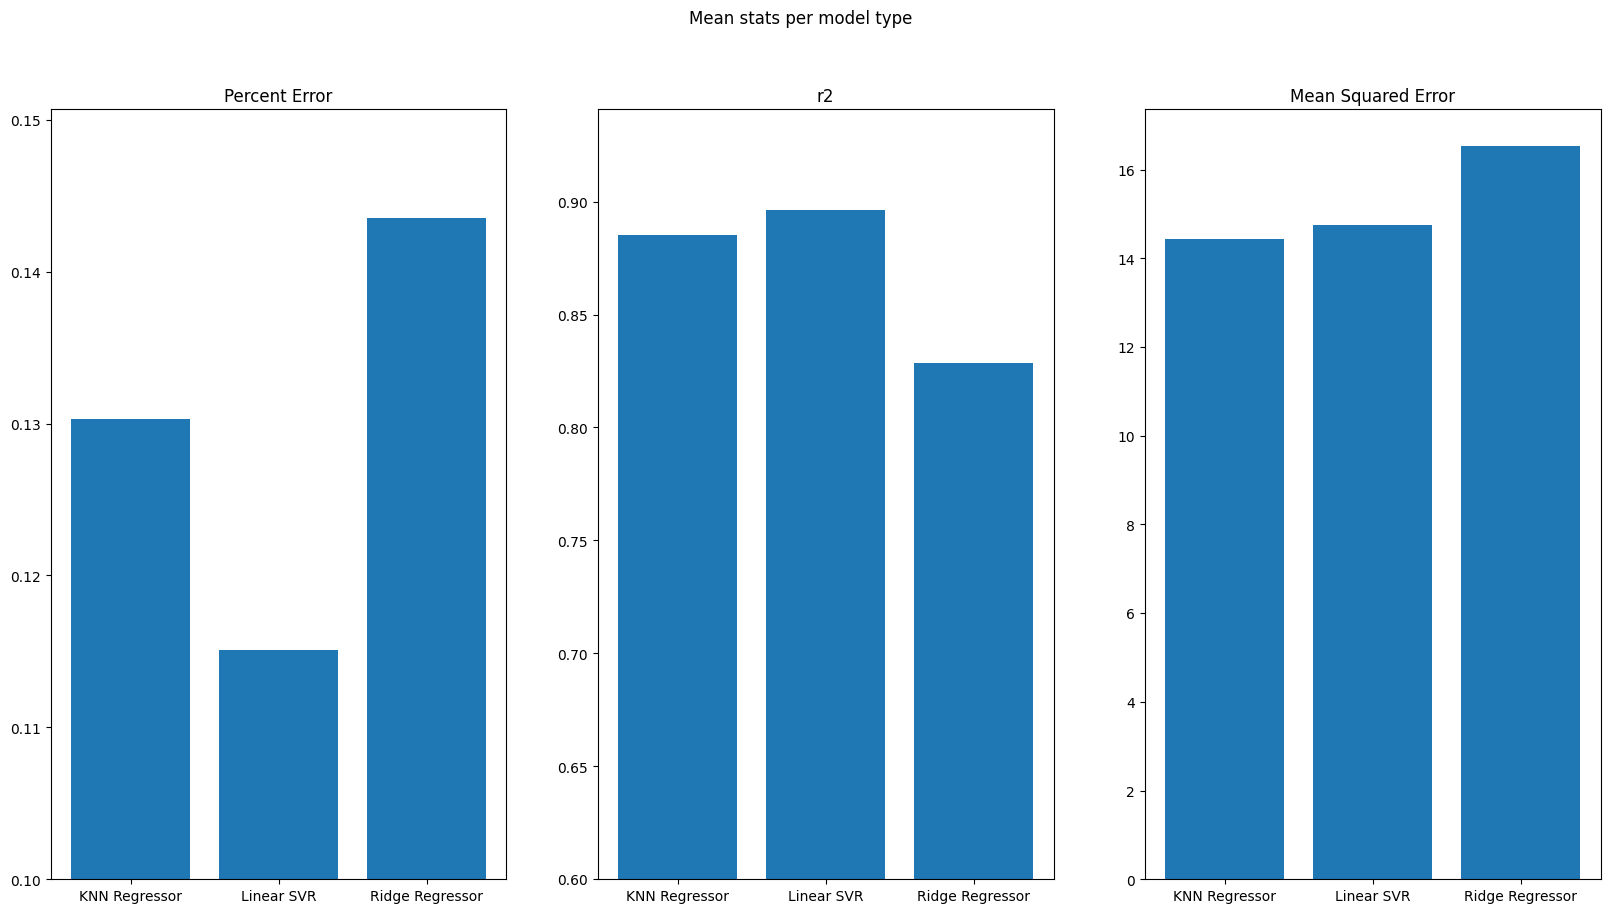

In [10]:
plt.figure(figsize=(20, 10))
plt.suptitle("Mean stats per model type")

plt.subplot(1, 3, 1)
plt.bar(results_df['Model'], results_df['mean_absolute_percentage'])
plt.ylim(0.1)
plt.title("Percent Error")

plt.subplot(1, 3, 2)
plt.bar(results_df['Model'], results_df['r2'])
plt.ylim(0.6)
plt.title("r2")

plt.subplot(1, 3, 3)
plt.bar(results_df['Model'], results_df['MSE'])
plt.title("Mean Squared Error")

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'displacement, cylinders, horsepower, weight, acceleration, model_year'),
  Text(1, 0, 'displacement, cylinders, horsepower, weight, model_year'),
  Text(2, 0, 'displacement, cylinders, horsepower, weight, acceleration'),
  Text(3, 0, 'model_year, cylinders, acceleration, weight, horsepower_by_displacement'),
  Text(4, 0, 'cylinders, horsepower, acceleration, weight_by_displacement'),
  Text(5, 0, 'horsepower, weight, acceleration, model_year, cylinders_by_displacement')])

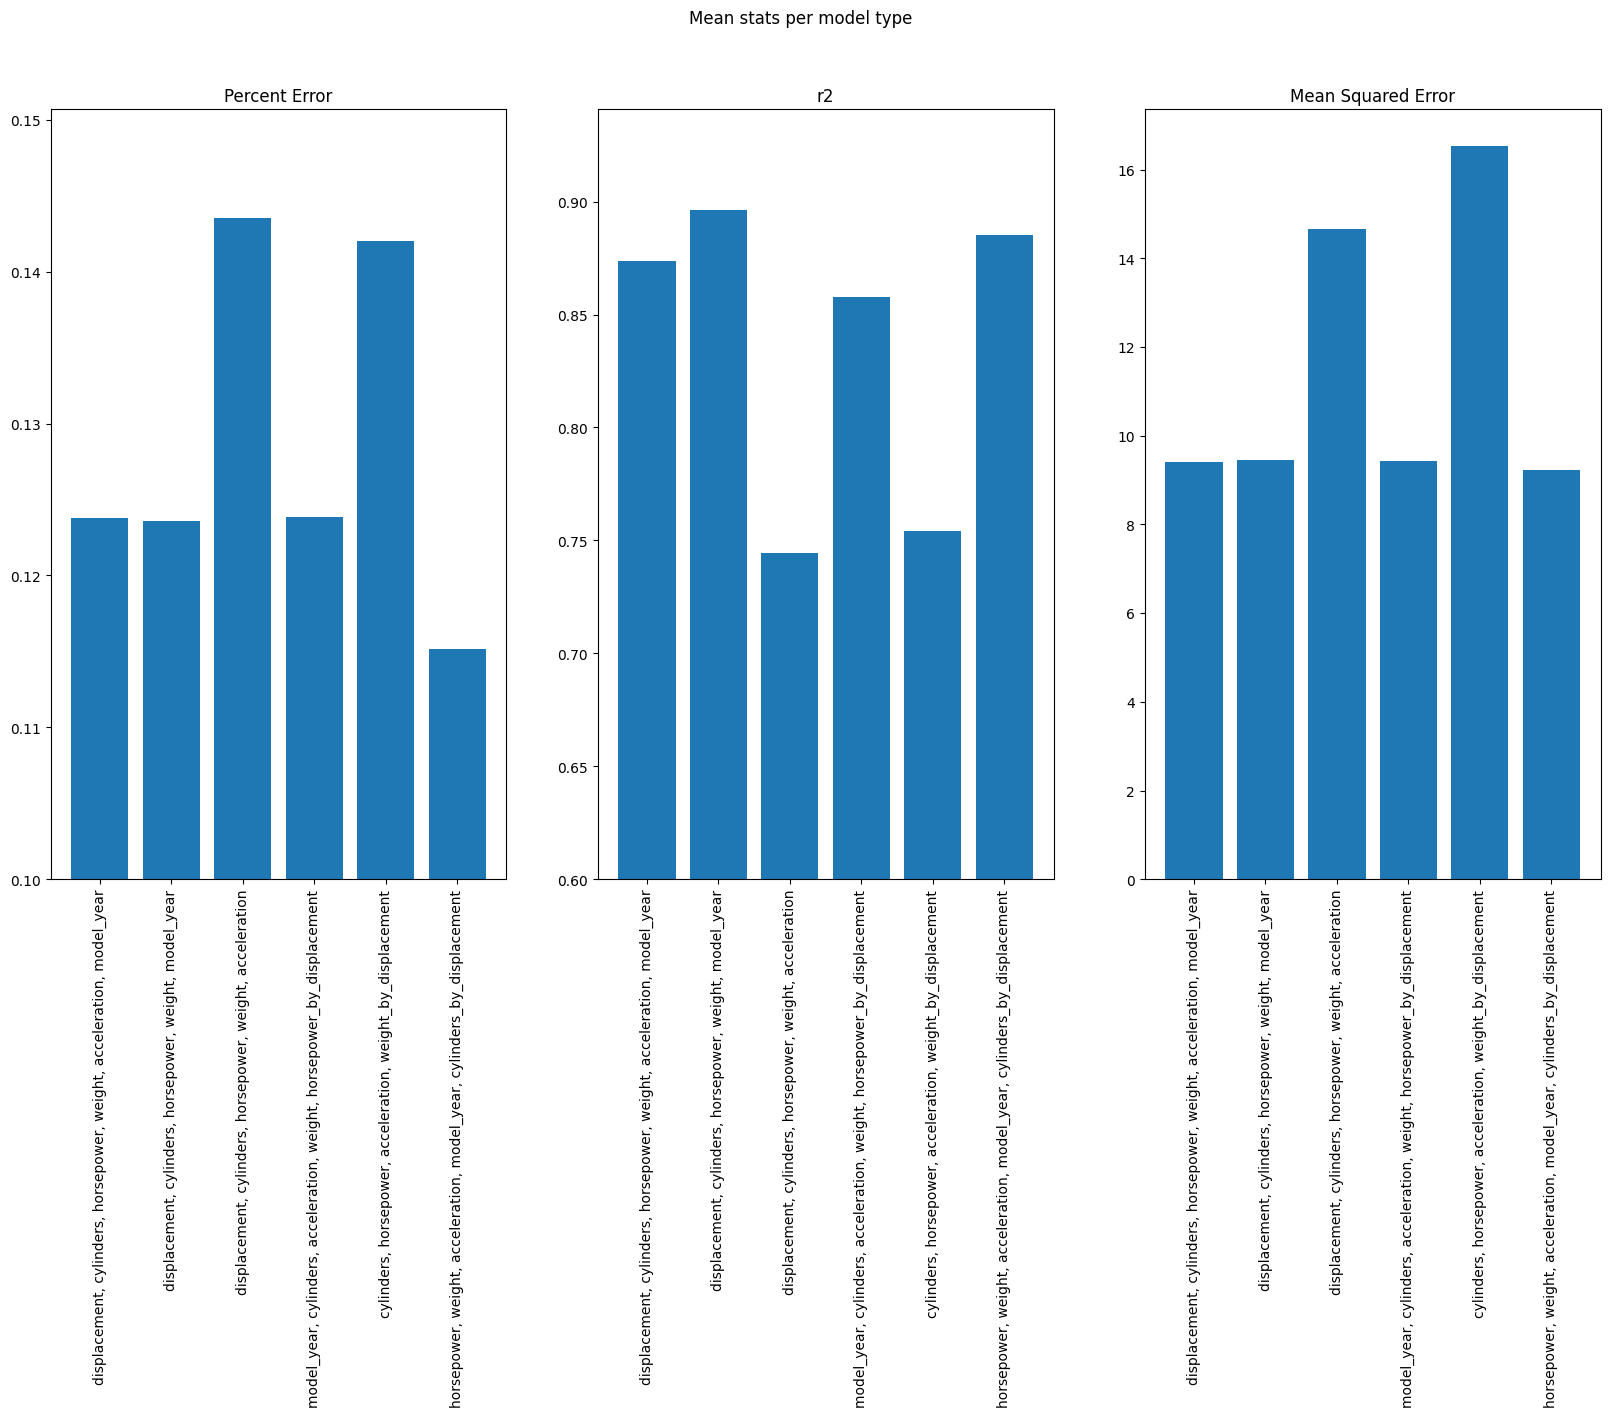

In [11]:
plt.figure(figsize=(20, 10))
plt.suptitle("Mean stats per model type")

plt.subplot(1, 3, 1)
plt.bar(results_df['Feature Set'], results_df['mean_absolute_percentage'])
plt.ylim(0.1)
plt.title("Percent Error")
plt.xticks( rotation='vertical')

plt.subplot(1, 3, 2)
plt.bar(results_df['Feature Set'], results_df['r2'])
plt.ylim(0.6)
plt.title("r2")
plt.xticks( rotation='vertical')

plt.subplot(1, 3, 3)
plt.bar(results_df['Feature Set'], results_df['MSE'])
plt.title("Mean Squared Error")
plt.xticks( rotation='vertical')